In [696]:
import pandas as pd


In [1]:
def proccess_annual_data(data):
    data.index=pd.to_datetime(data.Timestamp)
    cols = list(data.columns)
    power_cols = [s for s in cols if 'Active Power' in s and s[0].isdigit()]
    weather_cols = [s for s in cols if 'WeatherStation' in s]
    
    select_cols = power_cols + weather_cols
    
    new_power_cols = [s.split(' ')[0] for s in power_cols]
    new_weather_cols = [s.replace('DKA.WeatherStation - ',"") for s in weather_cols]
    
    new_cols = new_power_cols + new_weather_cols
    
    power_data = data[select_cols].fillna('0')
    power_data.columns = new_cols
    power_data=power_data.astype(float)
    
    return power_data

In [4]:
year_range = range(2012,2020)
master_data = pd.DataFrame()

for year in year_range:
    data = pd.read_csv('Alice_Springs_'+str(year)+'.csv')
    print('Extracting '+str(year))
    data = proccess_annual_data(data)
    master_data = master_data.append(data, sort=False)
 

Extracting 2012
Extracting 2013
Extracting 2014
Extracting 2015
Extracting 2016
Extracting 2017
Extracting 2018
Extracting 2019


# Inter-annual performance deccline

In [252]:
import statsmodels.api as sm
from scipy import stats

def normalised_decomposition(master_data,start,end):
    
    resampled = master_data[start:end].resample('W').mean()
    resampled = resampled.fillna('0').astype('float')
    normalized =(resampled-resampled.min())/(resampled.max()-resampled.min())
    decomposition = sm.tsa.seasonal_decompose(normalized, model='additive')
    
    return normalized, decomposition


def identify_ouput_decline(data, start, end, p_val):
     
    trend_stats = pd.DataFrame()
    
    for col in data.columns:
        sample = data.loc[start:end, col]
        x = list(range(len(sample)))
        y = sample.values
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        trend_stats.loc[col,'slope'] = slope
        trend_stats.loc[col,'intercept'] = intercept
        trend_stats.loc[col,'r_value'] = r_value
        trend_stats.loc[col,'p_value'] = p_value
        downs = trend_stats[(trend_stats.slope < 0)&(trend_stats.p_value < p_val)].index.values
    return trend_stats, downs


In [289]:
normalized, decomposition = normalised_decomposition(master_data,'2014','2019')

trend_stats, downs = identify_ouput_decline(decomposition.trend,'2015','2018',1e-25)



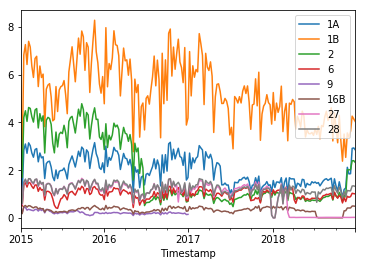

In [290]:
resampled.loc['2015':'2018',downs].plot()

In [264]:
resampled = master_data.resample('W').mean()
trend_stats, downs = identify_ouput_decline(resampled,'2014','2018',1e-3)

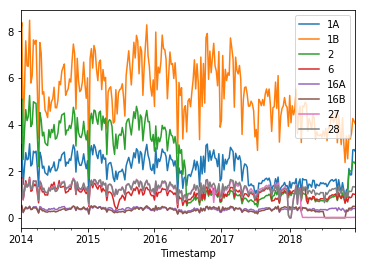

In [265]:
resampled.loc['2014':'2018',downs].plot()

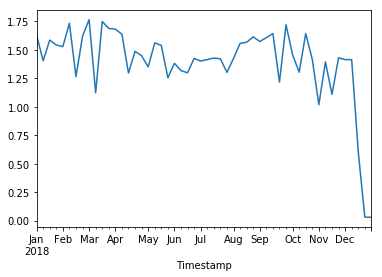

In [234]:
resampled.loc['2016':'2018','17'].plot()

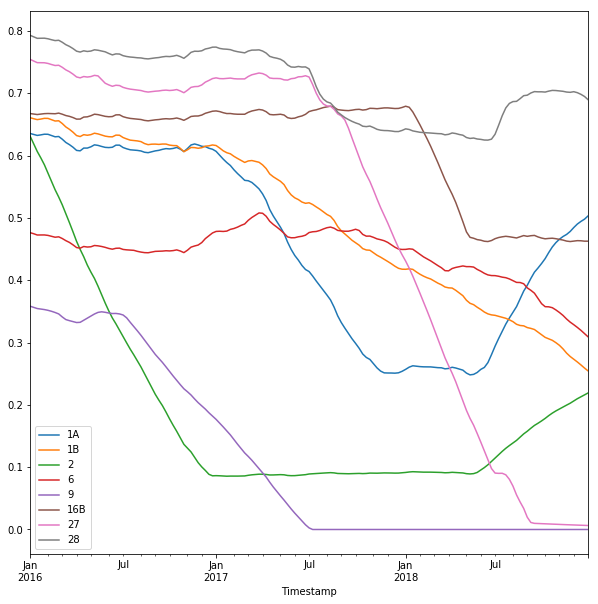

In [241]:
decomposition.trend.loc['2016':'2018',downs].plot(figsize=(10,10))

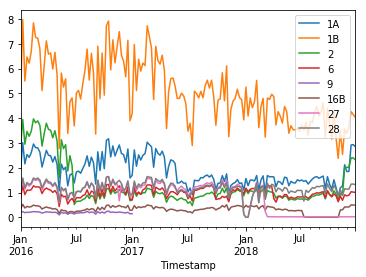

In [242]:
resampled.loc['2016':'2018',downs].plot()

In [246]:
trend_stats.loc[downs]

,slope,intercept,r_value,p_value
1A,-0.002437,0.647411,-0.761016,6.208499e-31
1B,-0.002723,0.710737,-0.979751,3.537784e-110
2,-0.001955,0.336165,-0.614619,1.109033e-17
6,-0.000642,0.493328,-0.678865,1.506942e-22
9,-0.002815,0.335086,-0.905336,1.588057e-59
16B,-0.001428,0.726121,-0.766647,1.243728e-31
27,-0.005436,0.932748,-0.893093,1.211293e-55
28,-0.000963,0.789472,-0.781271,1.534094e-33


,slope,intercept,r_value,p_value
1A,5.666048e-03,1.964630e-01,0.932479,9.295315e-24
1B,-3.069329e-03,4.227920e-01,-0.994765,3.336665e-51
2,2.854223e-03,6.109148e-02,0.944798,6.991794e-26
3,-1.446770e-06,6.363676e-01,-0.003320,9.813648e-01
4,4.490253e-03,3.415290e-01,0.867045,9.571653e-17
5,6.776894e-03,3.589173e-01,0.980018,9.805118e-37
6,-2.468674e-03,4.576050e-01,-0.958479,6.648024e-29
7,6.677311e-03,3.576407e-01,0.861826,2.350648e-16
8,6.823881e-06,6.522519e-01,0.016051,9.100769e-01
9,2.696122e-20,-1.283354e-17,0.003968,9.777289e-01


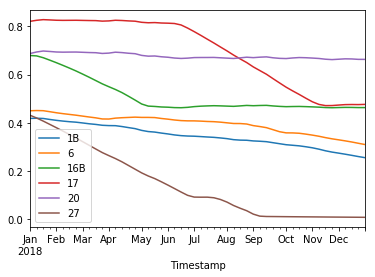

In [195]:
regressions.sort_values(by='slope')

,slope,intercept,r_value,p_value
27,-8.817312e-03,3.675388e-01,-0.954014,8.104434e-28
17,-8.685513e-03,9.197210e-01,-0.934512,4.433601e-24
16B,-3.780381e-03,6.059949e-01,-0.810316,3.404106e-13
1B,-3.069329e-03,4.227920e-01,-0.994765,3.336665e-51
6,-2.468674e-03,4.576050e-01,-0.958479,6.648024e-29
20,-6.761255e-04,6.938015e-01,-0.906469,2.348418e-20
16C,-3.109133e-04,5.530616e-01,-0.548053,2.603694e-05
21,-1.342699e-04,6.784282e-01,-0.303144,2.892167e-02
16A,-1.262301e-04,6.133846e-01,-0.325626,1.849095e-02
16D,-1.211488e-04,5.911812e-01,-0.230695,9.988584e-02


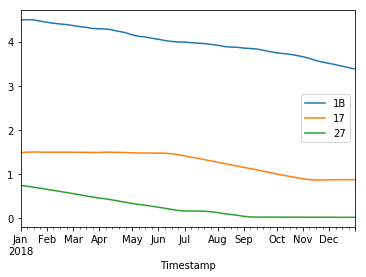

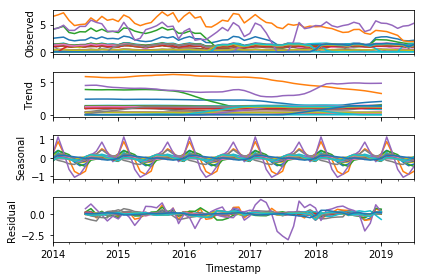

In [27]:
import matplotlib.pyplot as plt
fig = decomposition.plot()
plt.show()

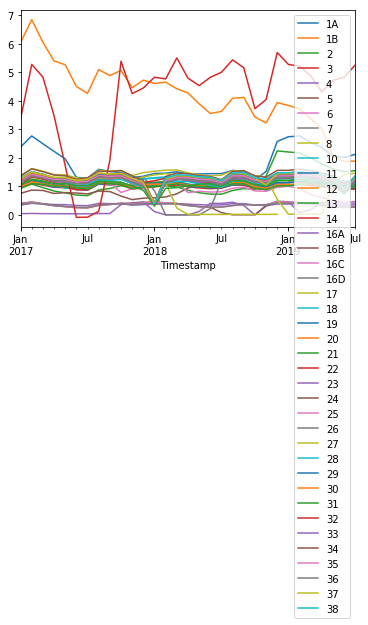

In [105]:
master_data.resample('M').mean().plot()


In [84]:
power_data = proccess_annual_data(data)




In [310]:


averages = master_data.groupby(master_data.index.hour).mean()

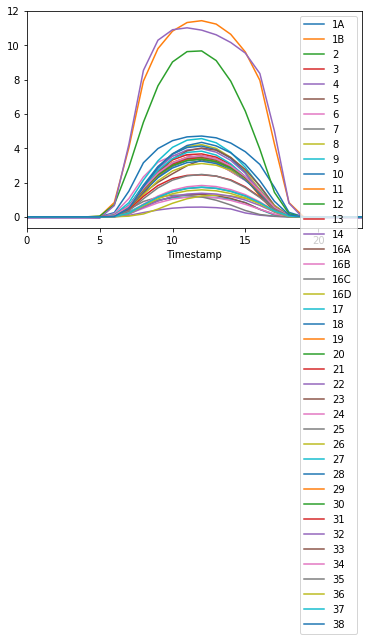

In [311]:
averages.plot()

In [314]:
norm_averages =(averages-averages.min())/(averages.max()-averages.min())

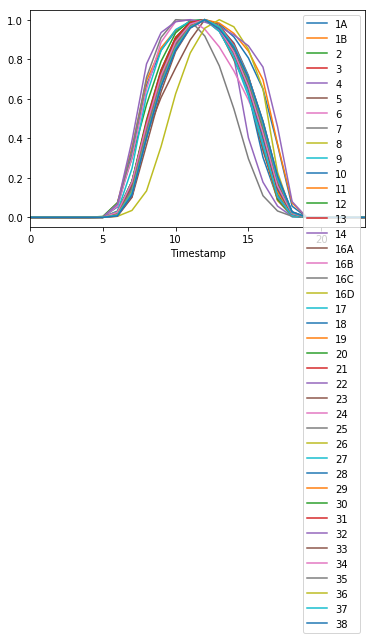

In [315]:
norm_averages.plot()

In [300]:
panel_meta_data = pd.read_csv('panel_meta_data.csv',index_col=0)

In [301]:
panel_meta_data

,Manufacturer,Array Rating,PV Technology,Array Structure,Installed,Panel Rating,Number Of Panels,Panel Type,Array Area,Type Of Tracker,Inverter Size / Type,Installation Completed,Array Tilt/Azimuth
1A,Trina,10.5kW,mono-Si,Tracker: Dual Axis,2009,175W,2 x 30,Trina TSM-175DC01,2 x 38.37 m²,"DEGERenergie 5000NT, dual axis","2 x 6 kW, SMA SMC 6000A","Thu, 8 Jan 2009",Variable. Dual axis tracking.
1B,Trina,23.4kW,mono-Si,Tracker: Dual Axis,2009,195W,4 x 30,Trina TSM-195DC01A,4 x 38.37 m²,"DEGERenergie 5000NT, dual axis","4 x 6 kW, SMA SMC 6000A","Thu, 8 Jan 2009",Variable: Dual axis tracking.
2,eco-Kinetics,26.52kW,mono-Si,Tracker: Dual Axis,2010,170W,156,eco-Kinetics ECOKES 170M,199.16 m²,"ADES 5F-27M, dual axis","3 x 9 kW, SMA SMC 9000TL-10","Mon, 23 Aug 2010",Fixed. Tilt = 20' Azimuth = 0'
3,BP Solar,4.95kW,poly-Si,Fixed: Ground Mount,2008,165W,30,BP 3165,37.75 m²,NaN,"6 kW, SMA SMC 6000A","Tue, 11 Nov 2008","Tilt = 20, Azi = 0 (Solar North)"
4,Kyocera,2.16kW,poly-Si,Tracker: Dual Axis,2008,135W,2 x 8,Kyocera KD135GX-LP,2 x 8.02 m²,Portasol dual axis,"2.5 kW, SMA SB 2500","Tue, 30 Sep 2008",NaN
5,Kyocera,5.4kW,poly-Si,Tracker: Single Axis,2008,135W,5 x 8,Kyocera KD135GX-LP,5 x 8.02 m²,BW Solar F2 5 Star Tracker,"5kW, SMA SMC 5000A","Tue, 30 Sep 2008",NaN
6,Kyocera,5.4kW,poly-Si,Tracker: Dual Axis,2008,135W,5 x 8,Kyocera KD135GX-LP,5 x 8.02 m²,Wattsun AZ-125 Tracker,"5 kW, SMA SMC 5000A","Sun, 30 Nov 2008",NaN
7,First Solar,6.96kW,CdTe,Fixed: Ground Mount,2008,73W,96,First Solar FS-272*,69.12 m²,NaN,"6 kW, Fronius Primo 6.0-1","Mon, 3 Nov 2008","Tilt = 20, Azi = 0 (Solar North)"
8,Kaneka,6kW,Other,Fixed: Ground Mount,2008,60W,100,Kaneka G-EA060,95.04 m²,NaN,"6 kW, SMA SMC 6000A","Tue, 11 Nov 2008","Tilt = 20, Azi = 0 (Solar North)"
9A,Solibro,5.2kW,CIGS,Fixed: Ground Mount,2017,130W,40,Solibro Hanergy SL2-130 G2.2,37.58m2,NaN,SMA SMC 6000A,"Fri, 20 Oct 2017",20 degrees


In [302]:
tracker_mask = panel_meta_data['Array Structure'].str.contains('Tracker')
fixed_mask = panel_meta_data['Array Structure'].str.contains('Fixed')

In [303]:
trackers = panel_meta_data[tracker_mask].index.values
fixed = panel_meta_data[fixed_mask].index.values

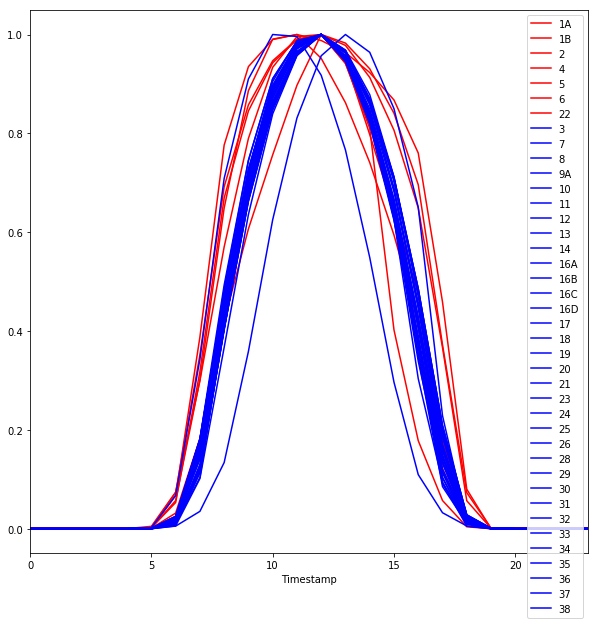

In [361]:
ax = norm_averages.loc[:,trackers].plot(color='Red',figsize=(10,10))
norm_averages.loc[:,fixed].plot(color='Blue',ax=ax)

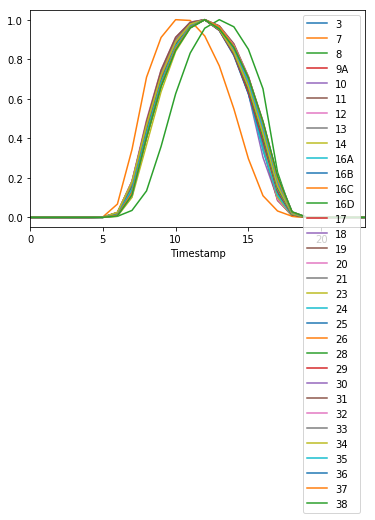

In [351]:
test = norm_averages.loc[:,fixed]
test = test[test==1].dropna(how='all')
test

,3,7,8,9A,10,11,12,13,14,16A,...,29,30,31,32,33,34,35,36,37,38
Timestamp,,,,,,,,,,,,,,,,,,,,,
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [353]:
print(test.loc[10][-test.loc[10].isna()])
print(test.loc[13][-test.loc[13].isna()])

16C    1.0
Name: 10, dtype: float64
16D    1.0
Name: 13, dtype: float64


In [354]:
# These are two arrays with non-zero azimuth values

In [397]:
# extract tilt and azimuth from texr
import re
panel_meta_data['Array Tilt/Azimuth']=panel_meta_data['Array Tilt/Azimuth'].astype('str')

angles = panel_meta_data['Array Tilt/Azimuth'].apply(lambda x: re.findall("\d+", x))

azimuth = []
tilt = []

for item in angles:
    try:
        azimuth.append(int(item[1]))
    except:
        azimuth.append(0)

    try:
        tilt.append(int(item[0]))
    except:
        tilt.append(0)

panel_meta_data['Tilt'] = tilt
panel_meta_data['Azim'] = azimuth

In [455]:
panel_meta_data['Array Area']=panel_meta_data['Array Area'].astype('str')

area_data = panel_meta_data['Array Area'].apply(lambda x: re.findall("\d*\.?\d+", x))
        
areas=[]
for item in area_data:
    try:
        try:
            areas.append(float(item[0])*float(item[1]))
        except:
            areas.append(float(item[0]))
    except:
        areas.append(0)
panel_meta_data['Array Area (m2)'] = areas
#panel_meta_data = panel_meta_data.drop('Array Area', axis =1)


panel_meta_data['Array Rating (kW)'] = panel_meta_data['Array Rating'].str.replace('kW','').astype(float)
#panel_meta_data = panel_meta_data.drop('Array Rating', axis =1)

In [490]:
panel_meta_data['Panel Rating (W)'] = panel_meta_data['Panel Rating'].str.replace('W','').astype(float)

In [492]:
panel_meta_data['Number Of Panels']=panel_meta_data['Number Of Panels'].astype('str')

panel_data = panel_meta_data['Number Of Panels'].apply(lambda x: re.findall("\d*\.?\d+", x))
        
panels=[]
for item in panel_data:
    try:
        try:
            panels.append(int(item[0])*int(item[1]))
        except:
            panels.append(int(item[0]))
    except:
        panels.append(0)
        
panel_meta_data['Number Of Panels (int)'] = panels



In [498]:
panel_meta_data['Installation Completed (datetime)']=pd.to_datetime(panel_meta_data['Installation Completed'] )

In [505]:
pv_tech_dummies = pd.get_dummies(panel_meta_data['PV Technology'])
structure_dummies = pd.get_dummies(panel_meta_data['Array Structure'])

In [506]:
panel_meta_data = pd.concat([panel_meta_data, pv_tech_dummies], axis=1, sort=False)
panel_meta_data = pd.concat([panel_meta_data, structure_dummies], axis=1, sort=False)

In [507]:
panel_meta_data

,Manufacturer,Array Rating,PV Technology,Array Structure,Installed,Panel Rating,Number Of Panels,Panel Type,Array Area,Type Of Tracker,...,Number Of Panels (int),Installation Completed (datetime),CIGS,CdTe,Other,mono-Si,poly-Si,Fixed: Ground Mount,Tracker: Dual Axis,Tracker: Single Axis
1A,Trina,10.5kW,mono-Si,Tracker: Dual Axis,2009,175W,2 x 30,Trina TSM-175DC01,2 x 38.37 m²,"DEGERenergie 5000NT, dual axis",...,60,2009-01-08,0,0,0,1,0,0,1,0
1B,Trina,23.4kW,mono-Si,Tracker: Dual Axis,2009,195W,4 x 30,Trina TSM-195DC01A,4 x 38.37 m²,"DEGERenergie 5000NT, dual axis",...,120,2009-01-08,0,0,0,1,0,0,1,0
2,eco-Kinetics,26.52kW,mono-Si,Tracker: Dual Axis,2010,170W,156,eco-Kinetics ECOKES 170M,199.16 m²,"ADES 5F-27M, dual axis",...,156,2010-08-23,0,0,0,1,0,0,1,0
3,BP Solar,4.95kW,poly-Si,Fixed: Ground Mount,2008,165W,30,BP 3165,37.75 m²,NaN,...,30,2008-11-11,0,0,0,0,1,1,0,0
4,Kyocera,2.16kW,poly-Si,Tracker: Dual Axis,2008,135W,2 x 8,Kyocera KD135GX-LP,2 x 8.02 m²,Portasol dual axis,...,16,2008-09-30,0,0,0,0,1,0,1,0
5,Kyocera,5.4kW,poly-Si,Tracker: Single Axis,2008,135W,5 x 8,Kyocera KD135GX-LP,5 x 8.02 m²,BW Solar F2 5 Star Tracker,...,40,2008-09-30,0,0,0,0,1,0,0,1
6,Kyocera,5.4kW,poly-Si,Tracker: Dual Axis,2008,135W,5 x 8,Kyocera KD135GX-LP,5 x 8.02 m²,Wattsun AZ-125 Tracker,...,40,2008-11-30,0,0,0,0,1,0,1,0
7,First Solar,6.96kW,CdTe,Fixed: Ground Mount,2008,73W,96,First Solar FS-272*,69.12 m²,NaN,...,96,2008-11-03,0,1,0,0,0,1,0,0
8,Kaneka,6kW,Other,Fixed: Ground Mount,2008,60W,100,Kaneka G-EA060,95.04 m²,NaN,...,100,2008-11-11,0,0,1,0,0,1,0,0
9A,Solibro,5.2kW,CIGS,Fixed: Ground Mount,2017,130W,40,Solibro Hanergy SL2-130 G2.2,37.58m2,NaN,...,40,2017-10-20,1,0,0,0,0,1,0,0


# Some attempts at solar calcualtions from scratch


In [765]:
import numpy as np
import datetime

def solar_declination(date_time):
    #http://usersupport.homerenergy.com/customer/en/portal/articles/2186872-how-homer-pro-calculates-the-radiation-incident-on-the-pv-array
    #https://pdfs.semanticscholar.org/0165/26e13439cc00b6599e073ae2889edf45f011.pdf
    n = date_time.timetuple().tm_yday

    #solar_dec = 23.45 * np.sin(np.deg2rad(360*((284 + n)/ 365)))
    
    solar_dec = -23.44 * np.cos(np.deg2rad((360/365)*(n+10)))
    #https://www.pveducation.org/pvcdrom/properties-of-sunlight/declination-angle
    return solar_dec




def solar_time_angle (date_time, time_zone, latitude, longitude):
    # time_zone : UTC +/- x
   
    n = date_time.timetuple().tm_yday
    

    
    B = (360/365) * (n-81)
    
    # Equation of time:
    E = 9.87 * np.sin(np.deg2rad(2*B)) - 7.53 * np.cos(np.deg2rad(B)) - 1.5 * np.sin(np.deg2rad(B)) 
    
    print('Equation of time: ' + str(E))
    
    # Local standard time Meridian
    LSTM = 15 * time_zone 
    
    # Time correction factor:
    
    TC = (4 * (longitude - LSTM) )  + E
    
    print('Time correction: ' + str(TC))
    solar_time = date_time + datetime.timedelta(minutes=TC)
    
    solar_time = pd.to_datetime(solar_time)
    
    print('Solar time: ' + str(solar_time))
    
    solar_hour =  solar_time.hour + solar_time.minute/60 + solar_time.second/3600

    print('Solar time (hr): ' + str(solar_hour))
    
    solar_angle = (15)*(solar_hour-12)
    
    print('Solar hour angle : ' + str(solar_angle))
    
    # solar declination
    solar_dec = solar_declination(date_time)
    print('Solar declination : '+ str(solar_dec))
    
    solar_dec = np.deg2rad(solar_dec)
    latitude = np.deg2rad(latitude)
    solar_angle = np.deg2rad(solar_angle)
    #elivation
    
    solar_eliv = np.arcsin( ( (np.sin(solar_dec) * np.sin(latitude)) + ((np.cos(latitude)) * np.cos(solar_dec) * np.cos(solar_angle)))  )
    
    print('Solar elivation :' + str(solar_eliv))
    
    #zenith
    solar_zenith = 90 - solar_eliv
    print('Solar zenith :' + str(solar_zenith))
     
    
    
    
    
    # solar zenith
    solar_zen = np.sin(latitude) * np.sin(solar_dec) + np.cos(latitude) * np.cos(solar_dec) * np.cos(solar_angle)
    
    print('Cosine of solar zenith : '+ str(solar_zen)) 
    
    return
    
    
    

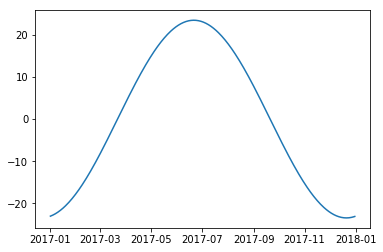

In [549]:
start_date = datetime.datetime.strptime("2017-01-01 00:00:00","%Y-%m-%d %H:%M:%S")
datelist = pd.date_range(start_date, periods=365).tolist()
angle = list(map(solar_declination,datelist))

plt.plot(datelist, angle)


Good, this is very close to values given in : https://www.pveducation.org/pvcdrom/properties-of-sunlight/declination-angle


In [766]:
# Test Case:
lat = 47.6062
long = -122.3321
UTC = -8
date = datetime.datetime.strptime("2017-01-20 14:00:00", "%Y-%m-%d %H:%M:%S")

solar_time_angle(date, UTC, lat, long)

# http://www.jgiesen.de/astro/suncalc/




Equation of time: -10.9643033372293
Time correction: -20.292703337229288
Solar time: 2017-01-20 13:39:42.437800
Solar time (hr): 13.661666666666667
Solar hour angle : 24.925000000000004
Solar declination : -20.383175286284562
Solar elivation :0.3214194745106676
Solar zenith :89.67858052548934
Cosine of solar zenith : 0.3159136587329537


In [754]:
np.cos(np.deg2rad(90.29488155922824))

-0.005146631391173624

In [698]:
data = pd.read_csv('Alice_Springs_'+str(year)+'.csv')

In [704]:
data.index = pd.to_datetime(data.Timestamp)

In [706]:
radiation = data[['DKA.WeatherStation - Global Horizontal Radiation (W/m²)','DKA.WeatherStation - Diffuse Horizontal Radiation (W/m²)']]


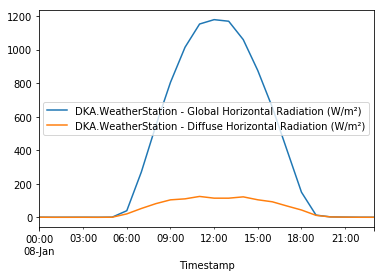

In [721]:
radiation['2019-01-08'].resample('H').mean().plot()

In [722]:
radiation.columns = ['Global Horizontal Radiation (W/m²)','Diffuse Horizontal Radiation (W/m²)']
radiation['']

https://github.com/pingswept/pysolar/blob/master/pysolar/solar.py
https://pvlib-python.readthedocs.io/en/latest/pvsystem.html